# Modelos lineales

El *modelo lineal* es una herramienta básica de estimación estadística, en particular para estudiar fenómenos *causa-efecto* y realizar regresión.

En el contexto de *series temporales* usaremos modelos lineales (y no lineales) con diferentes objetivos:

 * Obtener información de tendencia y estacionalidad de series.
 
 * Ajustar señales de una familia a una observación dada.
 
 * Ajustar valores de una serie a una función de los valores anteriores (ej: modelos autorregresivos)
 
La idea es repasar entonces cómo se realiza el ajuste de modelos lineales y aplicarlo a diferentes series.

## Regresión lineal en el contexto de series temporales.

Sea $\{x_t\}$, $t=1,\ldots,n$ una serie temporal. Queremos explicar su comportamiento a partir de variables independientes $z_{t_1},\ldots,z_{t_q}$ donde $q$ es la cantidad de variables explicativas en cada $t$.

**Nota:** En la regresión clásica estas variables son completamente independientes, pero en series temporales luego veremos como relajar esto.

Se tiene entonces el **Modelo de Regresión Lineal:**

$$x_t = \beta_1z_{t_1} + \ldots + \beta_qz_{t_q} + w_t.$$

* $\beta_1\ldots\beta_q$ son los parámetros a ajustar
* $z_{t_i}$ son las funciones de regresión a usar (a veces llamadas "features"), evaluadas en cada $t$.
* $w_t$ es ruido blanco (gaussiano) de varianza $\sigma_w^2$. 

### Ejemplo: estimación de una tendencia lineal

Consideremos los datos de temperatura `globtemp` disponibles en la biblioteca `astsa`. Al parecer estos datos tienen una tendencia creciente. Podemos usar un modelo lineal del tipo:

$$x_t = \beta_1 + \beta_2 t + w_t$$

Aquí $z_{t_1} = 1$ para todo $t$ y $z_{t_2} = t$. Tenemos dos parámetros ($q=2$) más la varianza del ruido o residuo $\sigma_w^2$.

In [1]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata
#Importo astsadata
import warnings
with warnings.catch_warnings(action="ignore"):
    import astsadata as astsa
    
## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
globtemp = astsa.gtemp #para mirar los datos
globtemp.T             #transpuesto para ocupar menos en pantalla. En general tratamos todo como columnas!!!

index,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
value,-0.28,-0.21,-0.26,-0.27,-0.32,-0.32,-0.29,-0.36,-0.27,-0.17,...,0.33,0.48,0.56,0.55,0.48,0.62,0.54,0.57,0.43,0.57


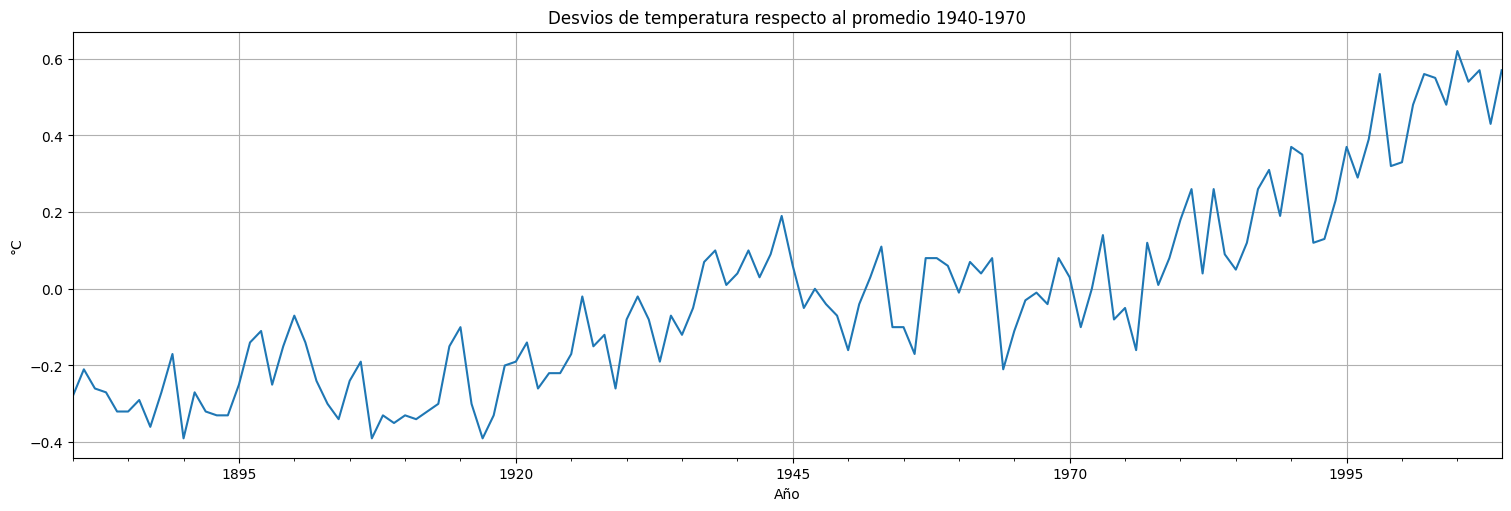

In [3]:
globtemp.plot(legend=False);
plt.title("Desvios de temperatura respecto al promedio 1940-1970")
plt.ylabel("°C")
plt.xlabel("Año");

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Extraigo la serie de años del índice de globtemp
time = pd.Series(globtemp.index.year, index=globtemp.index)
time = time - 1880 #elijo como año 0 el comienzo de la serie

#construyo un dataframe que tenga el tiempo en años y las temperaturas
data_reg = pd.concat([time, globtemp], axis=1)
data_reg.columns = ["time", "globtemp"]

#realizo el ajuste del modelo lineal por mínimos cuadrados
fit = ols(formula="globtemp ~ time", data=data_reg).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               globtemp   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     386.3
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           1.80e-40
Time:                        15:23:33   Log-Likelihood:                 86.718
No. Observations:                 130   AIC:                            -169.4
Df Residuals:                     128   BIC:                            -163.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3924      0.022    -17.978      0.000      -0.436      -0.349
time           0.0057      0.000     19.653      0.000       0.005       0.006
==============================================================================
Omnibus:                        0.646   Durbin-Watson:                   0.768
Prob(Omnibus):                  0.724   Jarque-Bera (JB):                0.738
Skew:                           0.013   Prob(JB):                        0.691
Kurtosis:                       2.632   Cond. No.                         148.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

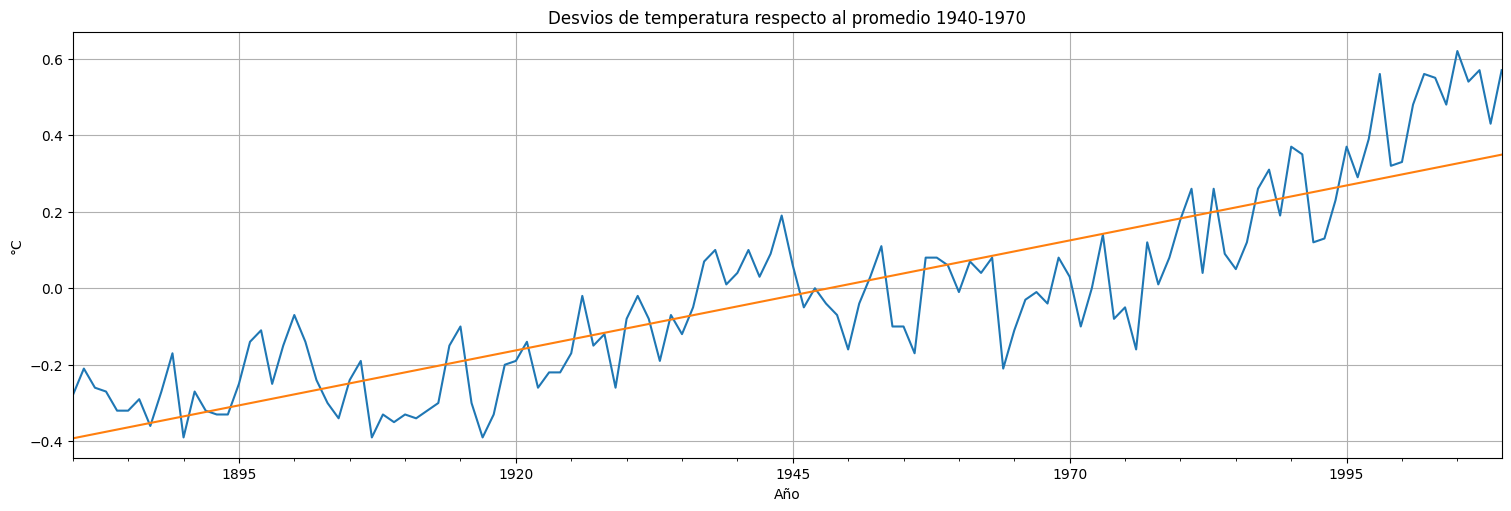

In [5]:
ax = globtemp.plot(xlabel="Time", ylabel="Temp deviation", legend=False)
ax.plot(fit.fittedvalues)
plt.title("Desvios de temperatura respecto al promedio 1940-1970")
plt.ylabel("°C")
plt.xlabel("Año");

**¿Cómo funciona?**

Conviene pasarse a notación vectorial, sean los vectores columna:

$$ z_t = (z_{t_1},\ldots,z_{t_q}), \quad \beta = (\beta_1,\ldots,\beta_q).$$

Entonces el valor en $t$ de la serie puede calcularse como:

$$ x_t = \beta^T z_t + w_t $$

(producto escalar de los vectores $\beta$ y $z_t$ más el ruido)

**Pregunta:** ¿Cómo podemos estimar $\beta$?

### Criterio de mínimos cuadrados

Se trata de minimizar la suma de los errores de predicción al cuadrado sobre todos los datos:

$$Q = \sum_{t=1}^n (x_t - \beta^T z_t)^2.$$

La minimización se hace en las variables $\beta_i$. El óptimo se denota $\hat{\beta}$, el estimador por mínimos cuadrados del modelo.

**Observación:** la minimización anterior tiene fórmula exacta!

#### Ecuaciones Normales

Derivando la ecuación anterior respecto a cada $\beta_i$ e imponiendo que las derivadas sean $0$ (condición de punto estacionario), se llega al siguiente sistema de ecuaciones para hallar $\hat{\beta}$:

$$\left(\sum_{t=1}^n z_t z_t^T\right)\hat{\beta} = \sum_{t=1}^n z_t x_t.$$

A dicho sistema lineal (de $q$ incógnitas) se le denominan "ecuaciones normales".

#### Versión matricial

Se puede simplificar aún más la notación definiendo la matriz:

$$ Z= \left[z_1|\ldots|z_n\right] $$

que tiene como columnas el valor de la función $z_{t_n}$ en cada $t$. Si $x=(x_1,\ldots,x_t)$ las ecuaciones normales quedan:

$$(Z^T Z) \hat{\beta} = Z^T x.$$

y la solución explícita es:

$$\hat{\beta} = (Z^T Z)^{-1} Z^T x.$$

Esto vale siempre que la matriz $(Z^T Z)$ sea invertible (en general si no lo es formulamos mal el modelo)

#### Ejemplo: ajuste lineal

Para el caso de un ajuste lineal:
$$x_t = \beta_1 + \beta_2 t + w_t$$
La matrix $Z$ en este caso es:

$$Z = \begin{pmatrix}
1 & t_1 \\
1 & t_2 \\
1 & t_3 \\
\vdots & \vdots \\
1 & t_n
\end{pmatrix}$$

siendo $t_i$ los tiempos de la muestra de la serie (ej: el año en `globtemp`).

#### Error cometido y Mean Square Error

El error cometido en la aproximación es simplemente la suma de los cuadrados:

$$\begin{align}
    SSE  &= \sum_{t=1}^n (x_t - \hat{\beta}^T z_t)^2 = (x-Z\hat{\beta})^T (x-Z\hat{\beta}) = x^Tx - \hat{\beta}^TZ^T x\\
         &= x^Tx - x^TZ(Z^TZ)^{-1}Z^T x
         \end{align}$$

El estimador $\hat{\beta}$ de mínimos cuadrados es insesgado, y si los errores son Gaussianos, es el estimador de máxima verosimilitud. En dicho caso podemos calcular la distribución esperada del estimador, la cual resulta una gaussiana de matriz de covarianzas, que permite calcular intervalos de confianza:

$$Cov(\hat{\beta}) = \sigma^2_w (Z^TZ)^{-1} = \sigma^2_w C.$$

El **Error Cuadrático Medio (MSE)** es simplemente:

$$s^2_w = MSE = \frac{SSE}{n-q}$$

y es un estimador insesgado para $\sigma_w^2$, la varianza del error.

### ¿Cómo podemos ver si el ajuste fue bueno?

1. Plotear los residuos. Deberían tener un comportamiento homogéneo.

2. Mirar si los residuos son gaussianos (`qqplot`). Esto no es necesario pero si lo son nos ajustamos al modelo anterior perfectamente.

3. Mirar si los residuos son "ruido blanco". Esta es una regla general: si luego de aplicar un modelo lo que queda es "ruido" es que logramos extraer toda la información.

4. Mirar si los mejoramos el ajuste respecto a algo simple (por ejemplo, la media) $\to$ Criterio $R^2$

5. Observar que no hubo sobreajuste (overfitting). Esto puede pasar si tengo demasiados parámetros. $\to$ Criterio de información ($AIC$, $BIC$).

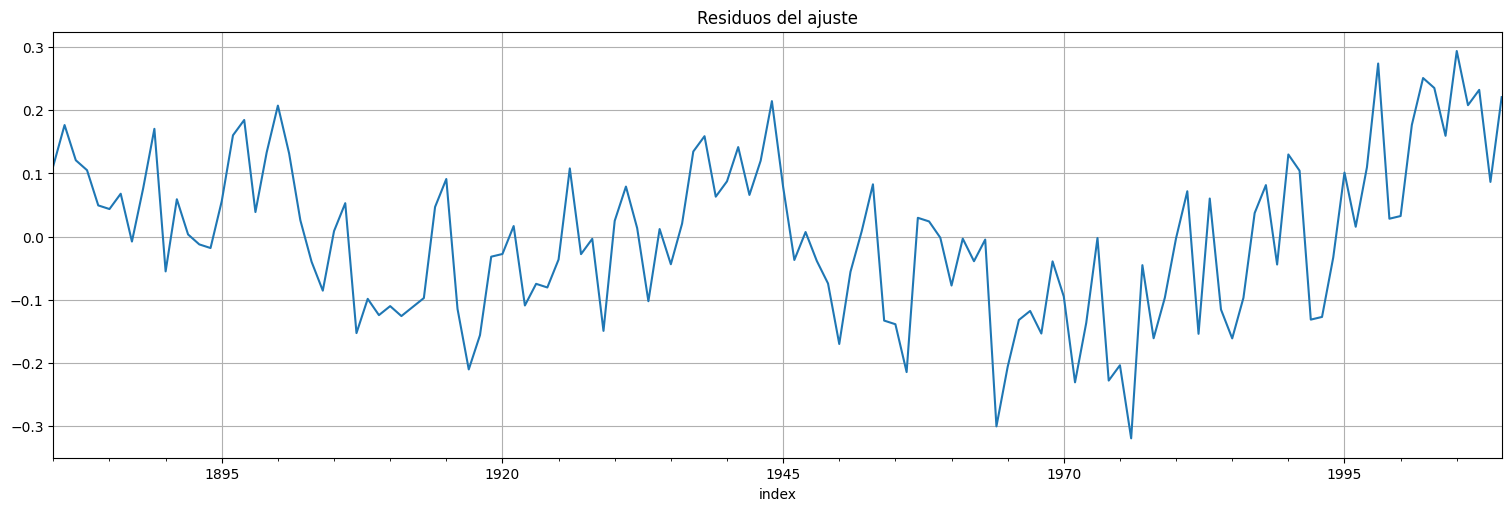

In [6]:
residuos = fit.resid
residuos.plot();
plt.title("Residuos del ajuste");

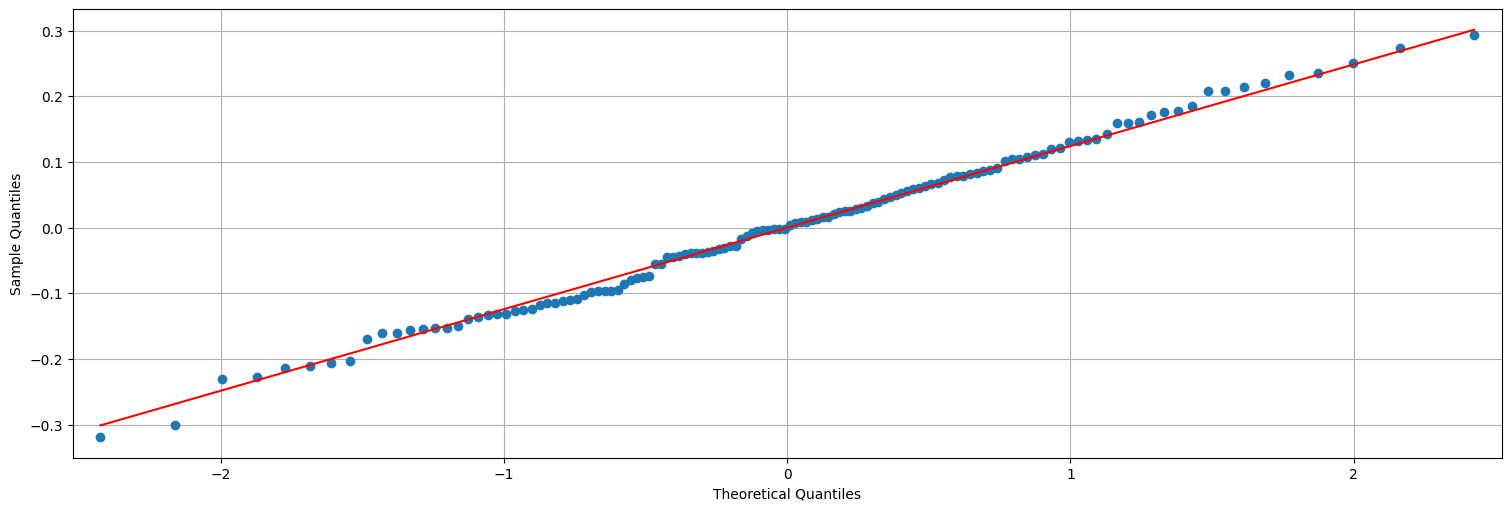

In [7]:
## QQ-plot es una verificación de gaussianidad.
sm.qqplot(residuos, line="s");

#### Nota:
Para calcular la acf, conviene utilizar `statsmodels.tsa.graphics.plot_acf()` con la opción `bartlett_confint=False` para usar el intervalo de confianza correcto

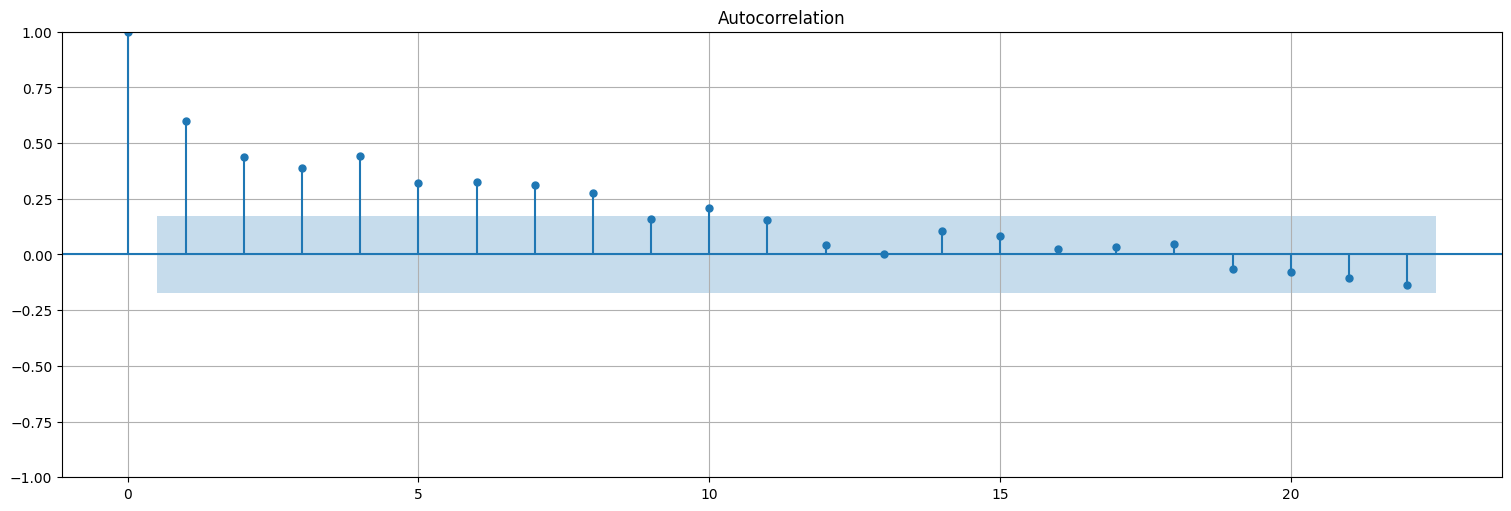

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuos, bartlett_confint=False);

**Nota:** Los residuos *no quedan ruido blanco*. Es decir que estrictamente no estamos en las hipótesis del modelo lineal. Más adelante veremos cómo mejorar esto.

### Evaluación:

Deseamos evaluar si mejoramos el ajuste respecto a algo simple. El modelo lineal más simple es:

$$x_t = \beta_1 + w_t.$$

Es decir, media más ruido. En este caso, la solución es $\hat{\beta}_1 = \bar{x}$, la media de los datos, y el error cuadrático $SSE_1$ es:

$$SSE_1 = \sum_{t=1}^n (x_t - \bar{x})^2.$$

Definimos:

$$R^2 = \frac{SSE_1 - SSE}{SSE_1}.$$

Entonces $R^2$ es una medida de correlación de nuestras variables $z$ con $x$, o bien cuánto mejora el ajuste en términos relativos respecto a la media.

In [9]:
SSE1 = np.sum((globtemp.values-np.mean(globtemp.values))**2, axis=0)
SSE = np.sum(fit.resid**2)
MSE = SSE/(globtemp.size - 2)
RMSE = np.sqrt(MSE)
R2 = (SSE1-SSE)/SSE1

#muestro los valores
print(f"SSE1: {SSE1}")
print(f"SSE: {SSE}")
print(f"MSE: {MSE}")
print(f"RMSE: {RMSE}")
print(f"R2: {R2}")

SSE1: [8.05436077]
SSE: 2.004767366480493
MSE: 0.01566224505062885
RMSE: 0.12514889152776723
R2: [0.75109541]


**Comparemos con el resumen del ajuste anterior:**

In [10]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               globtemp   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     386.3
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           1.80e-40
Time:                        15:23:33   Log-Likelihood:                 86.718
No. Observations:                 130   AIC:                            -169.4
Df Residuals:                     128   BIC:                            -163.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3924      0.022    -17.978      0.000      -0.436      -0.349
time           0.0057      0.000     19.653      0.000       0.005       0.006
==============================================================================
Omnibus:                        0.646   Durbin-Watson:                   0.768
Prob(Omnibus):                  0.724   Jarque-Bera (JB):                0.738
Skew:                           0.013   Prob(JB):                        0.691
Kurtosis:                       2.632   Cond. No.                         148.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Modelos lineales más complejos

Observemos que el modelo lineal general:

$$x_t = \beta_1z_{t_1} + \ldots + \beta_qz_{t_q} + w_t,$$

nada dice que la aproximación tenga que ser por una recta. De hecho es bastante general. Eligiendo los $z_{t_i}$ podemos hacer ajustes más complicados. La razón por la que se llama *lineal* es que los pesos $\beta_i$ entran linealmente en la ecuación, y admiten entonces resolverse por ecuaciones normales.


### Ejemplo: ajustar una tendencia cuadrática a las temperaturas.

Es simplemente considerar:

$$x_t = \beta_1 + \beta_2 t + \beta_3 t^2 + w_t$$

Aquí $z_{t_1} = 1$ para todo $t$, $z_{t_2} = t$ y $z_{t_3} = t^2$. Tenemos tres parámetros ($q=3$)

In [11]:
time2 = time**2

data_reg = pd.concat([time, time2, globtemp], axis=1)
data_reg.columns = ["time", "time2", "globtemp"]

fit2 = ols(formula="globtemp ~ time + time2", data=data_reg).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               globtemp   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     264.7
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           5.02e-46
Time:                        15:23:33   Log-Likelihood:                 103.09
No. Observations:                 130   AIC:                            -200.2
Df Residuals:                     127   BIC:                            -191.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2643      0.029     -9.210      0.000      -0.321      -0.208
time          -0.0003      0.001     -0.247      0.805      -0.002       0.002
time2       4.653e-05   7.71e-06      6.032      0.000    3.13e-05    6.18e-05
==============================================================================
Omnibus:                        0.679   Durbin-Watson:                   0.987
Prob(Omnibus):                  0.712   Jarque-Bera (JB):                0.765
Skew:                          -0.028   Prob(JB):                        0.682
Kurtosis:                       2.629   Cond. No.                     2.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

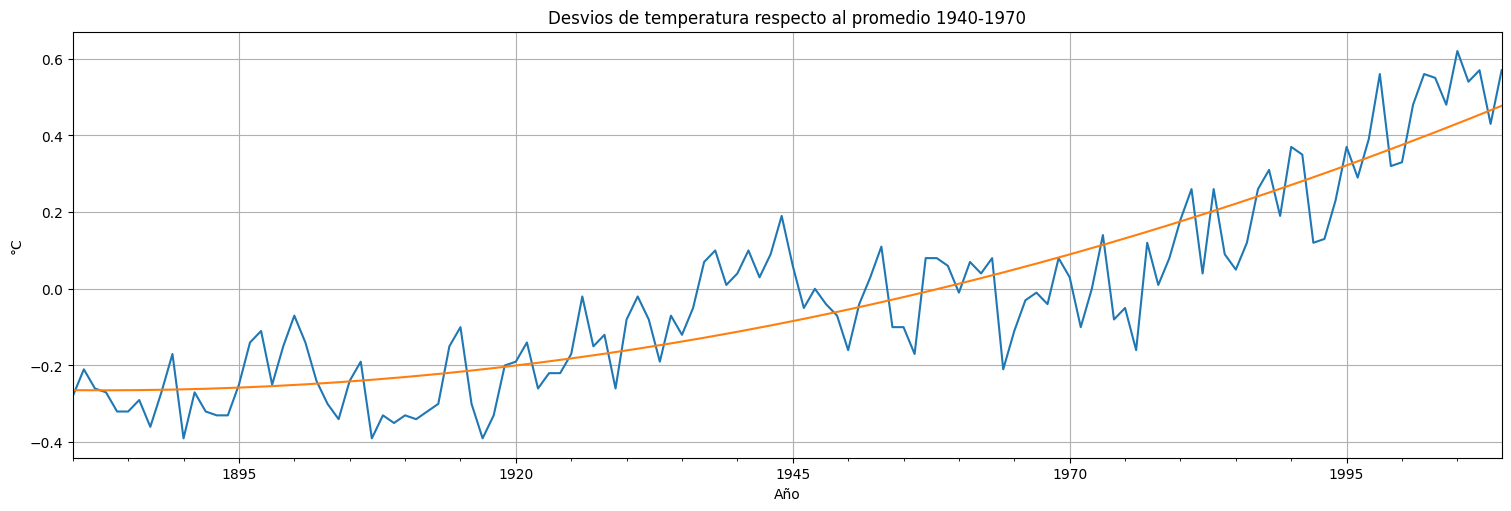

In [12]:
ax = globtemp.plot(xlabel="Time", ylabel="Temp deviation", legend=False)
ax.plot(fit2.fittedvalues)
plt.title("Desvios de temperatura respecto al promedio 1940-1970")
plt.ylabel("°C")
plt.xlabel("Año");

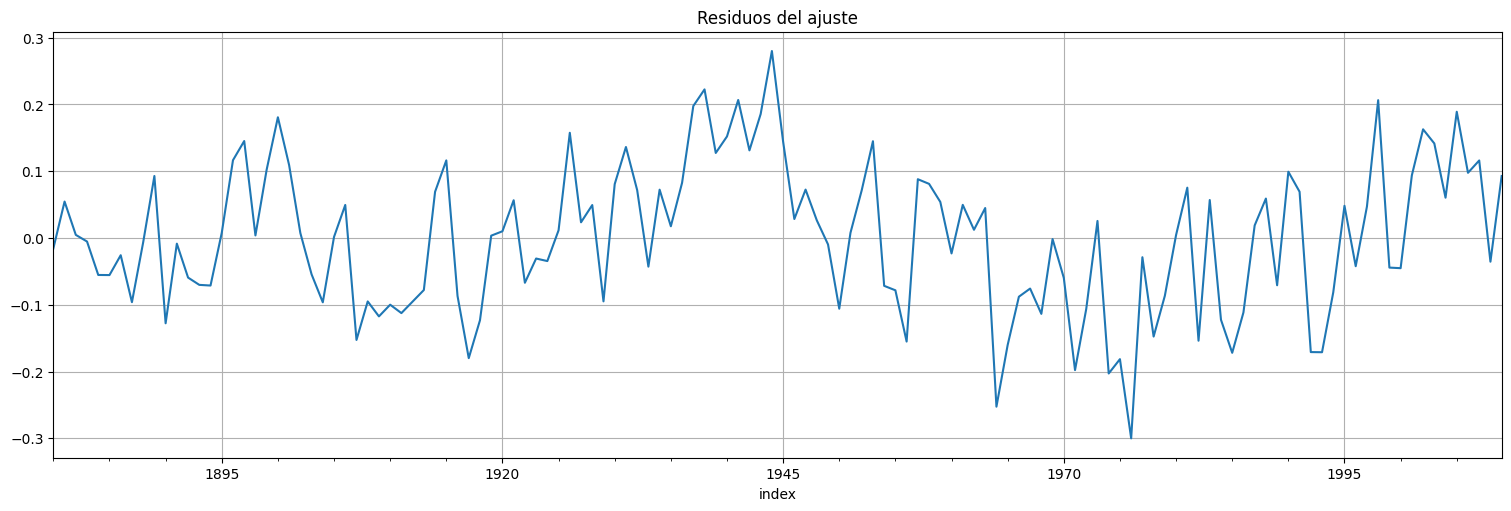

In [13]:
res2 = fit2.resid
res2.plot();
plt.title("Residuos del ajuste");

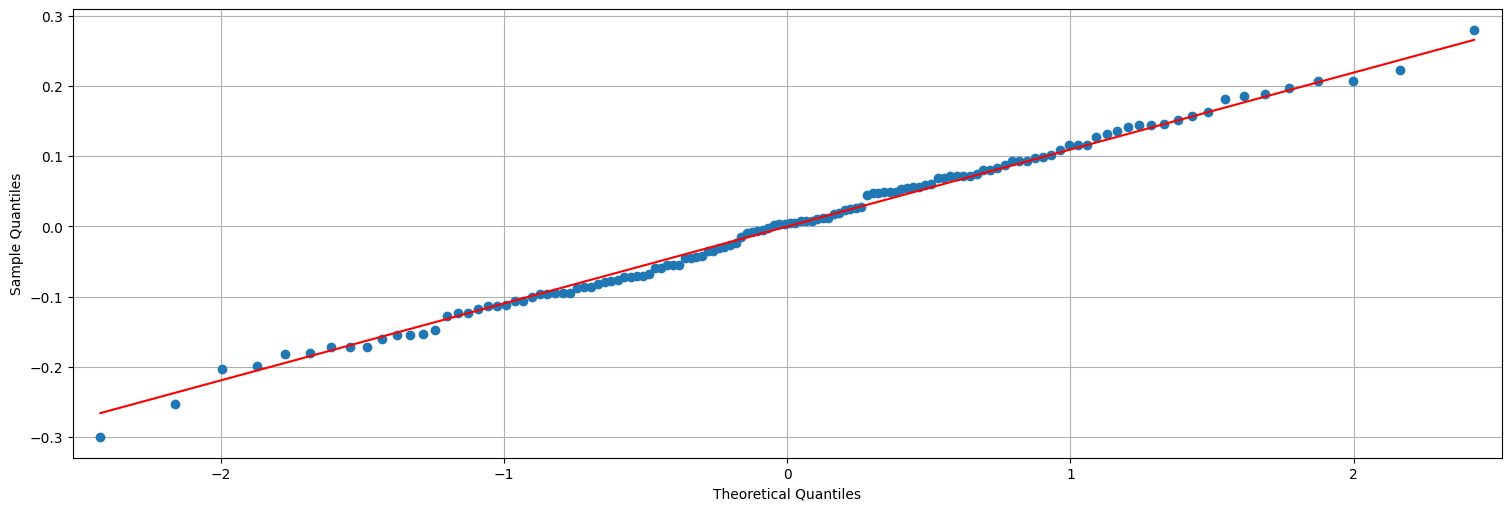

In [14]:
## QQ-plot es una verificación de gaussianidad.
sm.qqplot(res2, line="s");

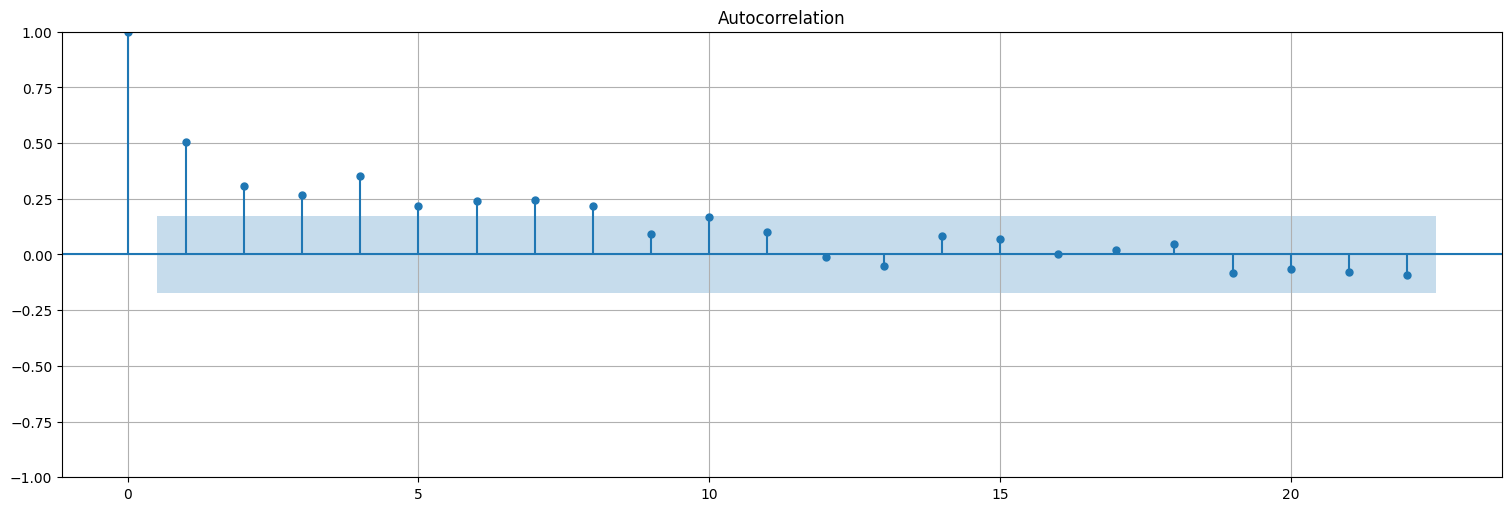

In [15]:
plot_acf(res2, bartlett_confint=False);

In [16]:
SSE1 = np.sum((globtemp.values-np.mean(globtemp.values))**2, axis=0)
SSE = np.sum(res2**2)
MSE = SSE/(globtemp.size - 3)
RMSE = np.sqrt(MSE)
R2 = (SSE1-SSE)/SSE1

#muestro los valores
print(f"SSE1: {SSE1}")
print(f"SSE: {SSE}")
print(f"MSE: {MSE}")
print(f"RMSE: {RMSE}")
print(f"R2: {R2}")

SSE1: [8.05436077]
SSE: 1.5583233958153067
MSE: 0.012270262959175642
RMSE: 0.1107712190019395
R2: [0.80652426]


## Akaike information criterion

Es una herramienta para selección de modelos. La idea es ponderar en parte la *verosimilitud del modelo* (calidad del ajuste) con la cantidad de parámetros involucrados (para prevenir el overfitting).

> **Definición (Akaike Information Criterion):** Se define el AIC de un ajuste como:
>
> $$AIC = -2\log \hat{L}_q + 2q.$$
>
> siendo $\hat{L}_q$ la log-verosimilitud. Cuanto más pequeño el AIC mejor.

En el caso de ajuste lineal con residuos gaussianos, la (log-)verosimilitud depende de la varianza de los residuos, es decir:

$$\hat{\sigma}_q^2 = \frac{SSE_q}{n},$$
siendo $q$ la cantidad de parámetros y $n$ la cantidad de muestras de la serie, como veremos a continuación.

### Verosimilitud del modelo

La hipótesis del modelo lineal es que los errores respecto al modelo son Gaussianas independientes de varianza $\sigma_w^2$. La verosimilitud se define entonces como:

$$L_q = \prod_{i=1}^n \frac{1}{\sqrt{2\pi}\sigma_w} e^{-r_t^2/(2\sigma_w^2)}$$

es decir, la densidad conjunta de los errores evaluada en los valores observados. A mayor densidad conjunta, más "chance" de que el modelo observado sea correcto (más verosimilitud).

En general conviene trabajar con la log-verosimilitud:

$$\log L_q = \sum_{t=1}^n \log\left[\frac{1}{\sqrt{2\pi}\sigma_w}\right] - \frac{r_t^2}{2\sigma_w^2} = -\frac{n}{2}\log(2\pi \sigma_w^2) - \sum_{t=1}^n \frac{r_t^2}{2\sigma_w^2}$$

Sustituyendo $\sigma_w^2$ por el valor estimado $\hat{\sigma}^2_w = SSE^2_q/n$ se tiene el estimador de la log-verosimilitud $\log \hat{L}_q$.

### Ejemplo:

Calculemos el AIC del ajuste lineal guardado en la variable `fit`:

In [17]:
n=globtemp.size
sigmaw2 = sum(res2**2)/n

logver = -n*np.log(np.sqrt(2*np.pi*sigmaw2)) - sum(res2**2/(2*sigmaw2))

print(f"Verosimilitud del ajuste: {logver}")

Verosimilitud del ajuste: 103.09304765571144


De aquí se deduce el AIC:

In [18]:
q=3 #parámetros estimados: intercept + trend + varianza del ruido
AIC = -2*logver + 2*q

print(f"AIC: {AIC}")

AIC: -200.1860953114229


## Bayesian information criterion

Es una herramienta análoga a la anterior, que penaliza distinto los parámetros involucrados.

> **Definición (Bayesian Information Criterion):** Se define el BIC de un ajuste como:
>
> $$BIC = -2\log \hat{L}_q + q\log(n)$$

Cuanto más pequeño el BIC mejor. Funciona mejor que el AIC en muestras grandes.

In [19]:
q=3 #parámetros estimados: intercept + trend + varianza del ruido
BIC = -2*logver + q*np.log(n)
print(f"BIC: {BIC}")

BIC: -191.58349196005614


### Comparación de ajustes

In [20]:
print(f"AIC:  Modelo lineal: {fit.aic} | Modelo cuadrático: {fit2.aic}")
print(f"AIC:  Modelo lineal: {fit.bic} | Modelo cuadrático: {fit2.bic}")

AIC:  Modelo lineal: -169.43681637260454 | Modelo cuadrático: -200.18609531142283
AIC:  Modelo lineal: -163.70174747169338 | Modelo cuadrático: -191.58349196005608


Vemos que el $AIC$ y el $BIC$ mejoran levemente en el ajuste cuadrático.

## Ejercicios

### Regresión con factores o "dummies".

Consideremos la serie $y_t$ de ganancias de Johnson & Johnson almacenada en `jj`. Se realiza la transformación $x_t = \log(y_t)$. Dicha transformación muestra los incrementos relativos o porcentuales (al pasar a logaritmo).

1. Ajustar un modelo de la forma:
$$
x_t = \beta_0 t + \sum_{i=1}^4 \beta_i Q_i(t) + w_t
$$
siendo $Q_i$ una función que vale $1$ si se está en el trimestre $i$ y $0$ si no.

3. Graficar los datos y superponer los datos ajustados.

4. Calcular los residuos y evaluar el ajuste.

### Señal en presencia de ruido.

Considere la señal generada más abajo, que consiste en una componente periódica más ruido. 

1. Ajuste un modelo de la forma:
$$
x_t = \beta_1 + \beta_2 \cos(2\pi t) + \beta_3 \sin(2\pi t) + w_t.
$$

3. Ajuste un modelo de la forma:
$$
x_t = \beta_1 + \beta_2 \cos(2\pi t) + \beta_3 \sin(2\pi t) + \beta_4 \cos(2\pi 2t) + \beta_5 \sin(2\pi 2t) + w_t.
$$

¿Qué captura este segundo modelo?

3. Compare los residuos y los ajustes en cada uno.

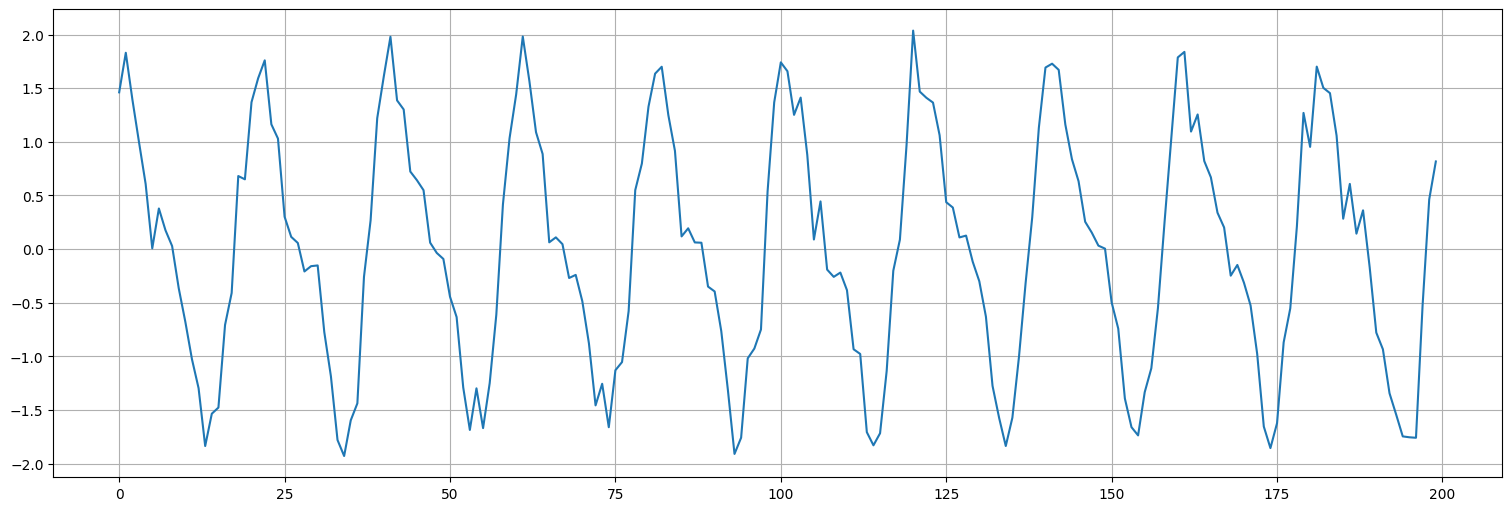

In [21]:
t = np.arange(0,10,0.05)
s = np.cos(2*np.pi*t) + np.sin(2*np.pi*t) + 0.5*np.cos(2*np.pi*2*t)
w = np.random.normal(size=t.size,loc=0,scale=0.2)
datos = s+w;
plt.plot(datos);